In [1]:
%pip install numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


# Import Library

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

# Load Dataset

In [7]:
# Extract ZIP
zip_path = "brain-tumor-mri-dataset.zip"
extract_path = "dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print(f"Dataset diekstrak ke: {extract_path}")


Dataset diekstrak ke: dataset


In [8]:
# Menentukan direktori setiap class
data_dir = extract_path
classes = ["glioma", "meningioma", "notumor", "pituitary"]

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    print(f"Class {cls} has {len(os.listdir(cls_path))} images.")

Class glioma has 1621 images.
Class meningioma has 1775 images.
Class notumor has 2000 images.
Class pituitary has 1757 images.


# Pre-Processing Data

In [9]:
img_height, img_width = 299, 299
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # Membagi dataset menjadi 80% training dan 20% validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 5723 images belonging to 4 classes.
Found 1430 images belonging to 4 classes.


# Exploratory Data Analysis (EDA)

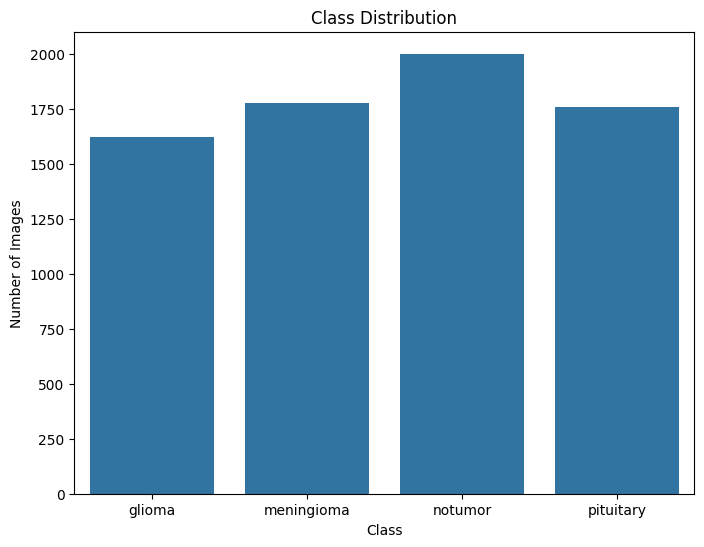

In [10]:
class_labels = list(train_generator.class_indices.keys())
data_counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=data_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


# CNN Model

In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


d:\Ari\Amikom\Semester 5\Big Data Mining\UAS\Project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,164,292 (76.92 MB)

 Trainable params: 20,164,292 (76.92 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train Model
epochs = 30
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)


d:\Ari\Amikom\Semester 5\Big Data Mining\UAS\Project\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.4241 - loss: 1.3557 - val_accuracy: 0.6238 - val_loss: 0.8817
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.5819 - loss: 0.9397 - val_accuracy: 0.6762 - val_loss: 0.8121
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.6662 - loss: 0.8282 - val_accuracy: 0.6825 - val_loss: 0.7553
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.6640 - loss: 0.8258 - val_accuracy: 0.7161 - val_loss: 0.6994
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.6688 - loss: 0.7868 - val_accuracy: 0.7210 - val_loss: 0.6806
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.7225 - loss: 0.7052 - val_accuracy: 0.7636 - val_loss: 0.6129
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.7358 - loss: 0.6814 - val_accuracy: 0.7636 - val_loss: 0.5923
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.7461 - loss: 0.6289 - val_accu

# Evaluasi Model

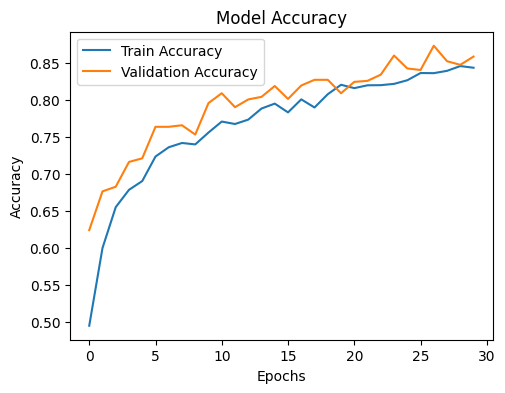

In [13]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


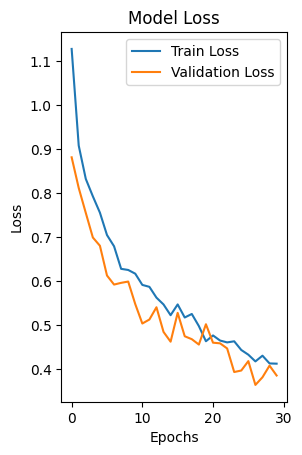

In [14]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [15]:
# Confusion Matrix and Classification Report
def evaluate_model(generator, model):
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(generator.classes, y_pred))
    print('Classification Report')
    print(classification_report(generator.classes, y_pred, target_names=generator.class_indices.keys()))

evaluate_model(validation_generator, model)


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 580ms/step
Confusion Matrix
[[ 72  75  89  88]
 [ 48  93 118  96]
 [ 77  95 118 110]
 [ 61  85 102 103]]
Classification Report
              precision    recall  f1-score   support

      glioma       0.28      0.22      0.25       324
  meningioma       0.27      0.26      0.26       355
     notumor       0.28      0.29      0.29       400
   pituitary       0.26      0.29      0.28       351

    accuracy                           0.27      1430
   macro avg       0.27      0.27      0.27      1430
weighted avg       0.27      0.27      0.27      1430

